In [2]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## TOP


In [5]:
############### upload data
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd

path ='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/new_processed_data/test.csv'

text_data = pd.read_csv(path, sep=',')
print(text_data)

                    id  ... identity_hate
0     6d5688fab66073c6  ...             1
1     64fc056641dba716  ...             0
2     ff5c60747f023cbd  ...             0
3     d4e23c86f5b1d708  ...             1
4     9a9dc24ba68e7597  ...             0
...                ...  ...           ...
3022  0cf27594013bb708  ...             0
3023  c04d00a14a202a94  ...             0
3024  b00ced343a0c5d8b  ...             1
3025  6ae73417bb0c7b61  ...             0
3026  fcda70fcb02196ce  ...             1

[3027 rows x 8 columns]


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext import data
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import argparse
import os
import datetime, time

In [42]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F
class Baseline(nn.Module):

    def __init__(self, embedding_dim, vocab):
        super(Baseline, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.fc = nn.Linear(embedding_dim, 6)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)

        average = embedded.mean(0)
        output = self.fc(average)
        output = nn.functional.sigmoid(output)

        return output.squeeze()

In [8]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim=100):
        super(CNN_LSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.hidden_dim = hidden_dim

        self.conv1 = nn.Conv2d(1, 100,kernel_size=(2,embedding_dim)) #in_channels, out_chanels, kernel_size
        
        
        self.lstm1 = nn.LSTM(embedding_dim,hidden_dim)
        target_size = 6
        self.fc1 = nn.Linear(hidden_dim, target_size)

    def forward(self, x, lengths):
    #   embeds = self.word_embeddings(sentence)
    #     lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
    #     tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    #     tag_scores = F.log_softmax(tag_space, dim=1)
    #     return tag_scores
        
        x = self.embedding(x)
        # print('x.shape',x.shape)

        x = x.unsqueeze(0)
        # print('x = x.unsqueeze(0)',x.shape)
        x = x.transpose(1,2) # swaps 2nd and 3rd dimension
        # print('x = x.transpose(1,2)',x.shape)
        x = x.transpose(0,1) # swaps 1st and 2nd dimension, now it has the correct input (n_samples,channels, height, width)
        # print('x = x.transpose(0,1)',x.shape)
        x1 = F.relu(self.conv1(x)) 
        # print('x1 = F.relu(self.conv1(x))',x1.shape)
        
        x1 = x1.squeeze(3)
        # print('x1 = x1.squeeze(3)',x1.shape)
        pool1 = nn.MaxPool1d(x1.size(2), 1) #maxpool
        
        x = pool1(x1)
        # print('pool1 = nn.MaxPool1d(x1.size(2), 1)',x.shape)
        x = x.squeeze(2)
        x = x.unsqueeze(0)
        # print('x = x.squeeze(2)',x.shape)


        #  pack the word embeddings in the batch together and 
        # run the RNN on this object
        # x = pack_padded_sequence(x,lengths) 
        # print('x.shape',x.shape)
        x,(h,c) = self.lstm1(x)
        # print('x.shape',x.shape)
        # print('h.shape',h.shape)
        # print('len(h)',len(h))
        # print('(x.view(len(lengths),-1)).shape',(x.view(len(lengths),-1)).shape)
        h_result = self.fc1(h.squeeze(0))
        # print('no sigmoid',h_result)
        # h_result = F.log_softmax(tag_space, dim=1) --> change to this with multiple cat
        h_result = torch.sigmoid(h_result)
        # print('sigmoid',h_result)
        

        return h_result

## model

In [20]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM_2_conv(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim=100):
        super(CNN_LSTM_2_conv, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.hidden_dim = hidden_dim

        self.conv1 = nn.Conv2d(1, 50,kernel_size=(2,embedding_dim)) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(1, 50,kernel_size=(2,embedding_dim)) #in_channels, out_chanels, kernel_size
        
        
        self.lstm1 = nn.LSTM(embedding_dim,hidden_dim)
        target_size = 6
        self.fc1 = nn.Linear(hidden_dim, target_size)

    def forward(self, x, lengths):
    #   embeds = self.word_embeddings(sentence)
    #     lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
    #     tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    #     tag_scores = F.log_softmax(tag_space, dim=1)
    #     return tag_scores
        
        x = self.embedding(x)
        # print('x.shape',x.shape)

        x = x.unsqueeze(0)
        # print('x = x.unsqueeze(0)',x.shape)
        x = x.transpose(1,2) # swaps 2nd and 3rd dimension
        # print('x = x.transpose(1,2)',x.shape)
        x = x.transpose(0,1) # swaps 1st and 2nd dimension, now it has the correct input (n_samples,channels, height, width)
        # print('x = x.transpose(0,1)',x.shape)
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x)) 
        # print('x1 = F.relu(self.conv1(x))',x1.shape)
        
        x1 = x1.squeeze(3)
        x2 = x2.squeeze(3)
        # print('x1 = x1.squeeze(3) hahaha',x1.shape)
        pool1 = nn.MaxPool1d(x1.size(2), 1)
        pool2 = nn.MaxPool1d(x2.size(2), 1) #maxpool
        
        x1 = pool1(x1)
        x2 = pool2(x2)
        # print('x1 = x1.squeeze(3) here',x1.shape)

        x = torch.cat((x1,x2),1)
        # print('pool1 = nn.MaxPool1d(x1.size(2), 1)',x.shape)
        # x = concat.view(-1,100)
        # print('x = x.',x.shape)
        
        x = x.transpose(1,2)
        # print('x === x.squeeze(1)',x.shape)
        x = x.transpose(0,1)
        # print('x === x.squeeze(0)',x.shape)


        #  pack the word embeddings in the batch together and 
        # run the RNN on this object
        # x = pack_padded_sequence(x,lengths) 
        # print('x.shape',x.shape)
        x,(h,c) = self.lstm1(x)
        # print('x.shape',x.shape)
        # print('h.shape',h.shape)
        # print('len(h)',len(h))
        # print('(x.view(len(lengths),-1)).shape',(x.view(len(lengths),-1)).shape)
        # print('h.shape',h.shape)
        # print('h.squeeze(0)',h.squeeze(0).shape)
        h_result = self.fc1(h.squeeze(0))
        # h_result = F.log_softmax(tag_space, dim=1) --> change to this with multiple cat
        # print('h_result.shape 1',h_result.shape)

        h_result = torch.sigmoid(h_result)
        # print('h_result.shape 2',h_result.shape)
        

        return h_result.squeeze(1)

## Training func

In [40]:
def trainRNN_R(seed = 0, batch_size = 64, learning_rate = 0.001, epochs = 5, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50):


  torch.manual_seed(seed)

  COMMENT_TEXT    = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
  TOXIC           = data.Field(sequential=False, use_vocab=False)
  SEVERE_TOXIC    = data.Field(sequential=False, use_vocab=False)
  OBSCENE         = data.Field(sequential=False, use_vocab=False)
  THREAT          = data.Field(sequential=False, use_vocab=False)
  INSULT          = data.Field(sequential=False, use_vocab=False)
  IDENTITY_HATE   = data.Field(sequential=False, use_vocab=False)

  train_data, val_data, test_data = data.TabularDataset.splits(
          path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/processed_data_aug_v2/', train='train.csv',
          validation='valid.csv', test='test.csv', format='csv',
          skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])

          # path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/multi_loose_large_data/', train='train.csv',
          # validation='valid.csv', test='test.csv', format='csv',
          # skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])

  train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size),sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)

  COMMENT_TEXT.build_vocab(train_data, val_data, test_data)

  COMMENT_TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
  vocab = COMMENT_TEXT.vocab

  print("Shape of Vocab:",COMMENT_TEXT.vocab.vectors.shape)   


  model = model(emb_dim, vocab)
  # model = model(vocab)

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  lossCount = []
  valLossCount = []
  accCount = []
  valAccCount = []
  testLossCount = []
  testAccCount = []
  epochCount = []
  
  for epoch in range(epochs):  # loop over the dataset multiple times
      correct = 0
      total = 0
      runningLoss = 0.0
      numberOfBatches = 0
      valCorrect = 0
      valRunningLoss = 0.0
      valNumberOfBatches = 0
      valTotal = 0

      testCorrect = 0
      testRunningLoss = 0.0
      testNumberOfBatches = 0
      testTotal = 0

      for i, batch in enumerate(train_iter, 0):
          # get the set of text sentences in the batch and length of the sentence sequences
          batch_input, batch_input_length = batch.text
          labels = []
          for i in range(len(batch.toxic)):
             labels += [[float(batch.toxic[i]), float(batch.severe_toxic[i]), float(batch.obscene[i]), float(batch.threat[i]),float(batch.insult[i]), float(batch.identity_hate[i])]]
          # print('(labels)',labels)
          labels=torch.FloatTensor(labels)
          # print('labels tensor size',labels.shape)
          # print('text tensor size',batch_input.shape)
          # labels = batch.toxic.float()    
          # print(labels)
      
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(batch_input, batch_input_length)
          loss = criterion(outputs, labels)
          # print('loss',loss)
          loss.backward()
          optimizer.step()   
          # print('labels',labels)      
          # print('outputs',outputs) 

          temp = ((outputs > 0.5).squeeze().long() == labels)
          # print('temp',temp)
          
          # correct = 0
          for i in temp:
            # if torch.equal(i, torch.BoolTensor([True, True, True, True, True, True])):
              # correct += 1
              # print('correct temp',i)
            correct += torch.count_nonzero(i)/len(i)

          # # evaluate training accuracy
          # with torch.no_grad():
          #   outputs = (outputs>0.5).float()
          #   correct += (outputs == labels).sum().item()
          
          # add training loss
          runningLoss += loss.item()

          # count the number of batches and samples
          numberOfBatches += 1
          total += labels.size(0)
          # print('total',total)



      # evaluate validation loss and 
      with torch.no_grad():
        for batch in val_iter:
          batch_input, batch_input_length = batch.text
          
          # labels = batch.toxic.float()   
          labels = []
          for i in range(len(batch.toxic)):
             labels += [[float(batch.toxic[i]), float(batch.severe_toxic[i]), float(batch.obscene[i]), float(batch.threat[i]),float(batch.insult[i]), float(batch.identity_hate[i])]]
          # print('(labels)',labels)
          labels=torch.FloatTensor(labels)

          outputs = model(batch_input, batch_input_length)
          loss = criterion(outputs, labels)
          valRunningLoss += loss.item()

          temp = ((outputs > 0.5).squeeze().long() == torch.FloatTensor(labels))
          # valCorrect = 0
          for i in temp:
            # if torch.equal(i, torch.BoolTensor([True, True, True, True, True, True])):
            #   valCorrect += 1
            valCorrect += torch.count_nonzero(i)/len(i)

          # outputs = (outputs>0.5).float()
          # valCorrect += (outputs == labels).sum().item()
          valTotal += labels.size(0)
          valNumberOfBatches += 1


      runningLoss = runningLoss/numberOfBatches
      print('correct',correct)
      correct = correct/total
      print('accuracy',correct)
      valRunningLoss = valRunningLoss/valNumberOfBatches
      valCorrect = valCorrect/valTotal
      # print statistics for every epoch)
      
      lossCount += [runningLoss]
      accCount += [correct]
      epochCount += [epoch+1]
      valLossCount += [valRunningLoss]
      valAccCount += [valCorrect]

      
      with torch.no_grad():
        for batch in test_iter:
          batch_input, batch_input_length = batch.text

          # labels = batch.toxic.float()   
          labels = []
          for i in range(len(batch.toxic)):
             labels += [[float(batch.toxic[i]), float(batch.severe_toxic[i]), float(batch.obscene[i]), float(batch.threat[i]),float(batch.insult[i]), float(batch.identity_hate[i])]]
          # print('(labels)',labels)
          labels=torch.FloatTensor(labels)

          outputs = model(batch_input, batch_input_length)
          loss = criterion(outputs, labels)
          testRunningLoss += loss.item()

          temp = ((outputs > 0.5).squeeze().long() == torch.FloatTensor(labels))
          # testCorrect = 0
          for i in temp:
            # if torch.equal(i, torch.BoolTensor([True, True, True, True, True, True])):
            #   testCorrect += 1
            testCorrect += torch.count_nonzero(i)/len(i)


          # outputs = (outputs>0.5).float()
          # testCorrect += (outputs == labels).sum().item()
          testTotal += labels.size(0)
          testNumberOfBatches += 1
      testRunningLoss = testRunningLoss/testNumberOfBatches
      testLossCount += [testRunningLoss]
      testAccCount += [testCorrect/testTotal]

      print('[%d] train loss: %.3f, train acc: %.3f, validation loss: %.3f, validation acc: %.3f , test accuracy is %.3f and loss is %.3f' %
                    (epoch + 1, runningLoss, correct, valRunningLoss, valCorrect,testCorrect/testTotal, testRunningLoss))
      
  
  #plot
  plt.title("Loss Curve")
  plt.plot(epochCount, lossCount, label="Training")
  plt.plot(epochCount, valLossCount, label="Validation")
  plt.plot(epochCount, testLossCount, label="Testing")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()


  plt.title("Accuracy Curve")
  plt.plot(epochCount, accCount, label = "Training")
  plt.plot(epochCount, valAccCount, label = "Validation")
  plt.plot(epochCount, testAccCount, label="Testing")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  torch.save(model,'model_rnn.pt')

## train


Shape of Vocab: torch.Size([45459, 100])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


correct tensor(19455.4043)
accuracy tensor(0.7505)
[1] train loss: 0.639, train acc: 0.750, validation loss: 0.629, validation acc: 0.779 , test accuracy is 0.776 and loss is 0.632
correct tensor(20045.5254)
accuracy tensor(0.7732)
[2] train loss: 0.628, train acc: 0.773, validation loss: 0.626, validation acc: 0.767 , test accuracy is 0.769 and loss is 0.628
correct tensor(20156.2129)
accuracy tensor(0.7775)
[3] train loss: 0.625, train acc: 0.778, validation loss: 0.624, validation acc: 0.777 , test accuracy is 0.779 and loss is 0.626
correct tensor(20218.8848)
accuracy tensor(0.7799)
[4] train loss: 0.624, train acc: 0.780, validation loss: 0.623, validation acc: 0.785 , test accuracy is 0.784 and loss is 0.625
correct tensor(20269.6133)
accuracy tensor(0.7819)
[5] train loss: 0.623, train acc: 0.782, validation loss: 0.622, validation acc: 0.776 , test accuracy is 0.778 and loss is 0.624
correct tensor(20273.1953)
accuracy tensor(0.7820)
[6] train loss: 0.623, train acc: 0.782, val

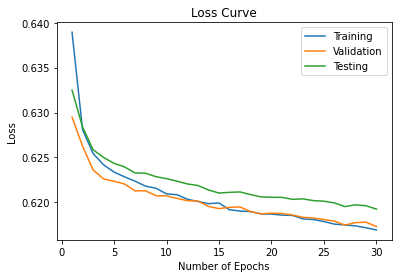

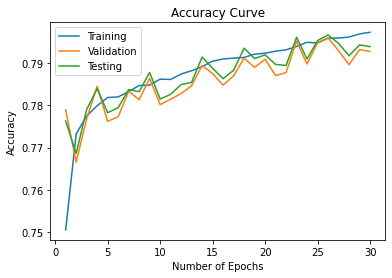

In [44]:
trainRNN_R(seed = 0, batch_size = 64, learning_rate = 0.01, epochs = 30, model = Baseline, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50)

In [31]:
def get_vocab(seed = 0, batch_size = 64, learning_rate = 0.001, epochs = 5, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50):


  torch.manual_seed(seed)

  COMMENT_TEXT    = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
  TOXIC           = data.Field(sequential=False, use_vocab=False)
  SEVERE_TOXIC    = data.Field(sequential=False, use_vocab=False)
  OBSCENE         = data.Field(sequential=False, use_vocab=False)
  THREAT          = data.Field(sequential=False, use_vocab=False)
  INSULT          = data.Field(sequential=False, use_vocab=False)
  IDENTITY_HATE   = data.Field(sequential=False, use_vocab=False)

  train_data, val_data, test_data = data.TabularDataset.splits(
          path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/processed_data_aug_v2/', train='train.csv',
          validation='valid.csv', test='test.csv', format='csv',
          skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])

          # path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/multi_loose_large_data/', train='train.csv',
          # validation='valid.csv', test='test.csv', format='csv',
          # skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])

  train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size),sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)

  COMMENT_TEXT.build_vocab(train_data, val_data, test_data)

  COMMENT_TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
  vocab = COMMENT_TEXT.vocab

  print("Shape of Vocab:",COMMENT_TEXT.vocab.vectors.shape)   
  def save_vocab(vocab):
    import pickle
    output = open('together_vocab.pkl', 'wb')
    pickle.dump(vocab, output)
    output.close()
  save_vocab(vocab)

get_vocab(seed = 0, batch_size = 64, learning_rate = 0.01, epochs = 30, model = CNN_LSTM_2_conv, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50)

Shape of Vocab: torch.Size([45459, 100])


In [34]:
import pickle
import math

def tokenizer(string):
    nlp = spacy.load('en')
    return nlp(string)

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def subjective_bot(model_path, vocab_path):
  model_baseline = torch.load(model_path)

  with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

  while True:

      print("Enter a sentence")
      sentence = input()

      sentencelist = tokenizer(sentence)
      temp = []
      for i in range(len(sentencelist)):
          temp.append(vocab.stoi[str(sentencelist[i])])
      sentence_tensor = torch.LongTensor([temp]).permute(1, 0)
      sentence_length = torch.LongTensor([len(temp)])

      baseline = model_baseline(sentence_tensor, sentence_length)
      print(baseline)

In [35]:
subjective_bot('/content/model_rnn.pt','/content/together_vocab.pkl')

Enter a sentence
Hi how are you
tensor([[1.0000e+00, 1.1181e-08, 2.8568e-08, 1.4434e-08, 2.2504e-08, 1.2679e-08]],
       grad_fn=<SqueezeBackward1>)
Enter a sentence
I hate you
tensor([[1.0000e+00, 1.1181e-08, 2.8568e-08, 1.4434e-08, 2.2504e-08, 1.2679e-08]],
       grad_fn=<SqueezeBackward1>)
Enter a sentence
I want to kill you
tensor([[1.0000e+00, 1.1181e-08, 2.8568e-08, 1.4434e-08, 2.2504e-08, 1.2679e-08]],
       grad_fn=<SqueezeBackward1>)
Enter a sentence
oh no all answers are the same
tensor([[1.0000e+00, 1.1181e-08, 2.8568e-08, 1.4434e-08, 2.2504e-08, 1.2679e-08]],
       grad_fn=<SqueezeBackward1>)
Enter a sentence
fuck fuck
tensor([[1.0000e+00, 7.8641e-08, 1.0000e+00, 3.2821e-08, 1.0000e+00, 2.8854e-08]],
       grad_fn=<SqueezeBackward1>)
Enter a sentence
you are so disgusting
tensor([[1.0000e+00, 1.1210e-08, 2.8522e-08, 1.4478e-08, 2.2491e-08, 1.2721e-08]],
       grad_fn=<SqueezeBackward1>)
Enter a sentence


KeyboardInterrupt: ignored